# Final Code Coverage (Single Parameter) 

This is a Notebook used to determine if adaptive parameter control have any effect on the final coverage.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


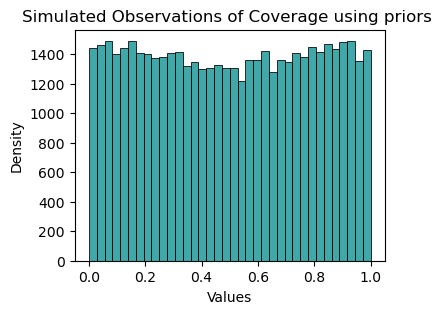

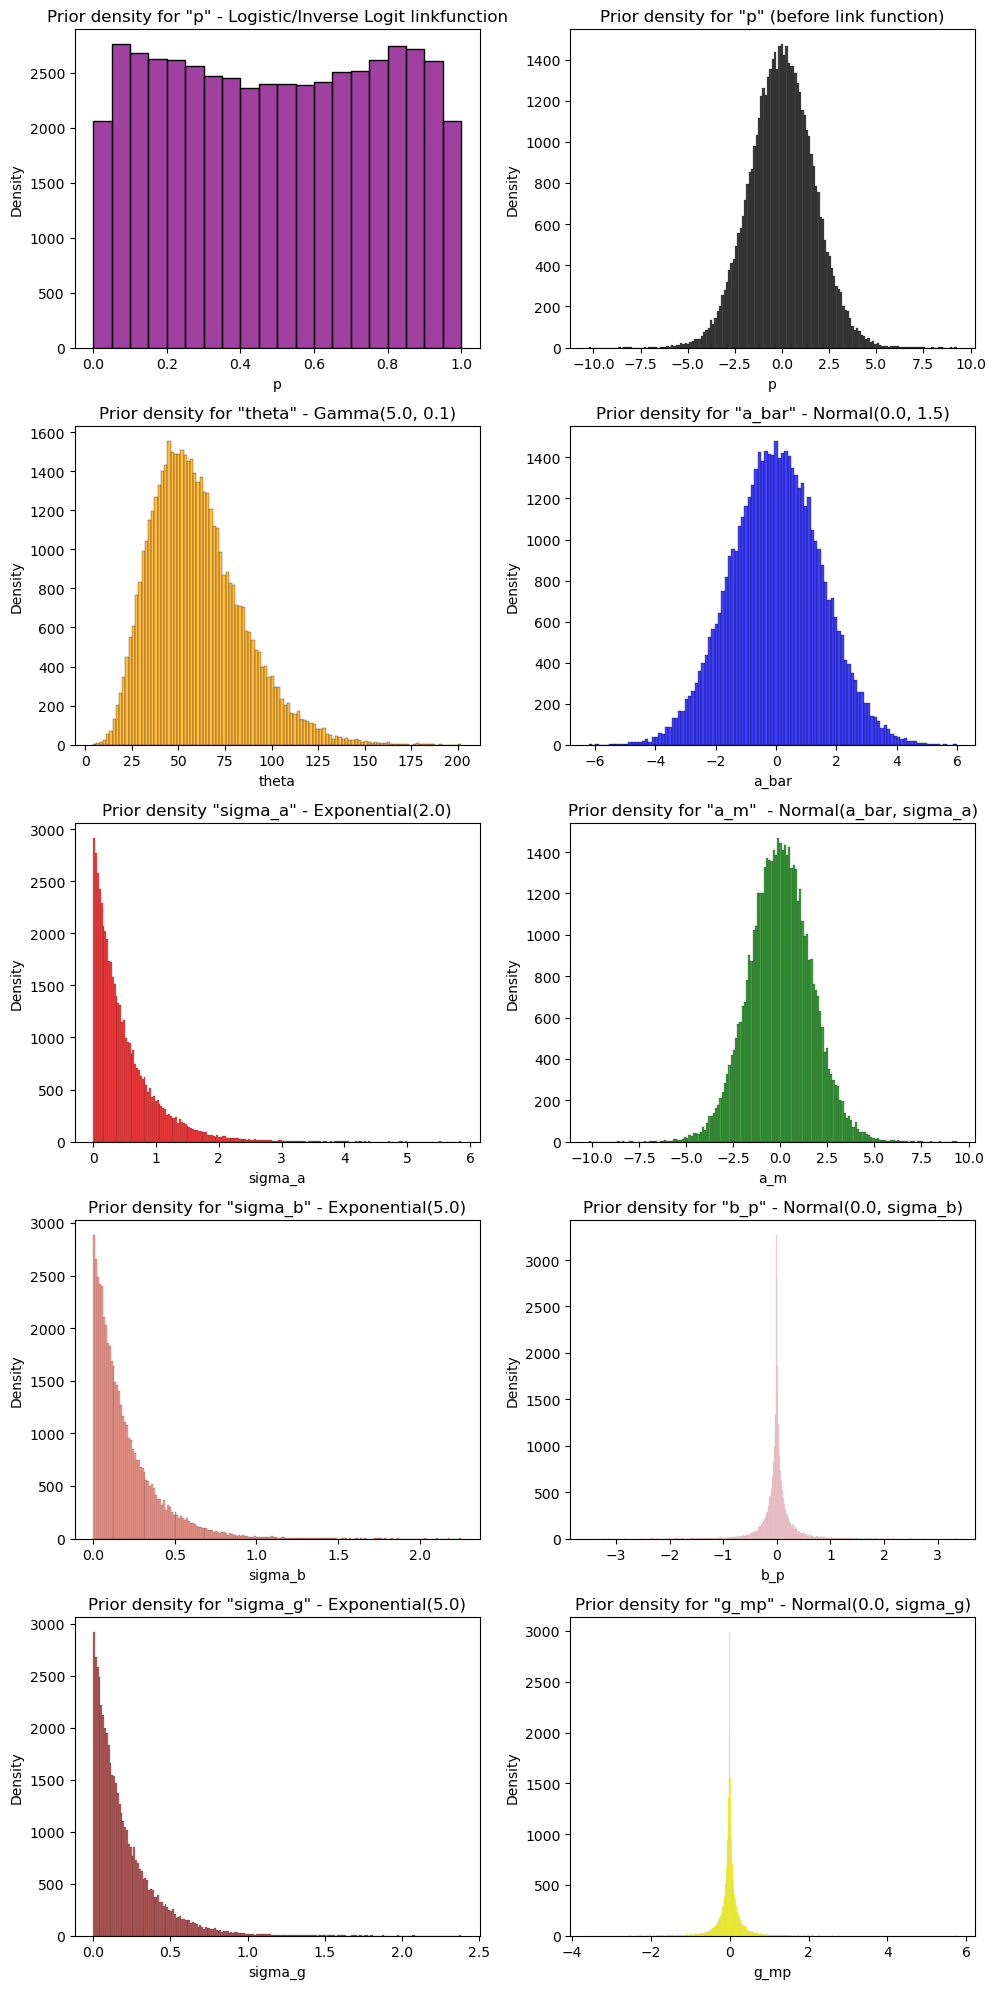

In [5]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard deviation for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)
        

        # Link function (logit), from unbounded to (0,1) probability
        pm.Deterministic('p_before', (a_m + b_p + g_mp))        
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=6, beta= 0.1)

        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=50000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Use alpha and beta as parameters for the a Beta distribution
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    # Plot histogram of observaions 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()

    # Plot priors for the different parameters
    plots = [
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior density for "p" - Logistic/Inverse Logit linkfunction', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior density for "p" (before link function)', 'p', 'black'),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior density for "theta" - Gamma(5.0, 0.1)', 'theta', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior density for "a_bar" - Normal(0.0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior density "sigma_a" - Exponential(2.0)', 'sigma_a', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior density for "a_m"  - Normal(a_bar, sigma_a)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior density for "sigma_b" - Exponential(5.0)', 'sigma_b', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior density for "b_p" - Normal(0.0, sigma_b)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior density for "sigma_g" - Exponential(5.0)', 'sigma_g', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior density for "g_mp" - Normal(0.0, sigma_g)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


calc_prior_dist(2, 5, 5, 0, 1.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, )


# Model specification

### Data Preperation

In [6]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'Coverage')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 5.0)
    sigma_g = pm.Exponential('sigma_g', 5.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), from unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beata distribution likelihood with parameter alpha and beta
    theta = pm.Gamma('theta', alpha=6, beta= 0.1) # Dispersion/spread parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "final_coverage_model_single_parameter.nc")

# Data analysis


### Generate summary object (without transformations)

In [7]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("model_3_trace_1000.nc") # REPLACE
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    #'a_m': logit_to_probability,
    #'a_bar': logit_to_probability,
    #'sigma_a': logit_to_probability
    #'b_p': log_to_exp,
    #'g_mp':logit_to_probability
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)

### Replace numeric identifiers with descriptive identifiers

In [8]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[packages],-2.908,0.034,-2.963,-2.855,0.001,0.000,4376.0,3211.0,1.00
a_m[cmd],-2.492,0.029,-2.538,-2.444,0.000,0.000,3549.0,2961.0,1.00
a_m[dict_unpacking],-1.817,0.025,-1.854,-1.773,0.000,0.000,4346.0,3220.0,1.00
a_m[signals],-1.417,0.022,-1.451,-1.380,0.000,0.000,4702.0,3362.0,1.00
a_m[return_from_generator],-1.223,0.022,-1.259,-1.188,0.000,0.000,4063.0,3218.0,1.00
a_m[python],-1.216,0.021,-1.248,-1.180,0.000,0.000,4127.0,3129.0,1.00
a_m[py_base],-0.951,0.021,-0.985,-0.918,0.000,0.000,4355.0,2783.0,1.00
a_m[positional_validation],-0.911,0.020,-0.944,-0.880,0.000,0.000,4469.0,2697.0,1.00
a_m[journaling],-0.738,0.020,-0.771,-0.706,0.000,0.000,4360.0,3000.0,1.00
g_mp[return_from_generator x Pop],-0.225,0.057,-0.318,-0.137,0.001,0.001,1916.0,2011.0,1.00


### Plot the prior distributions and their assosicated trace plots

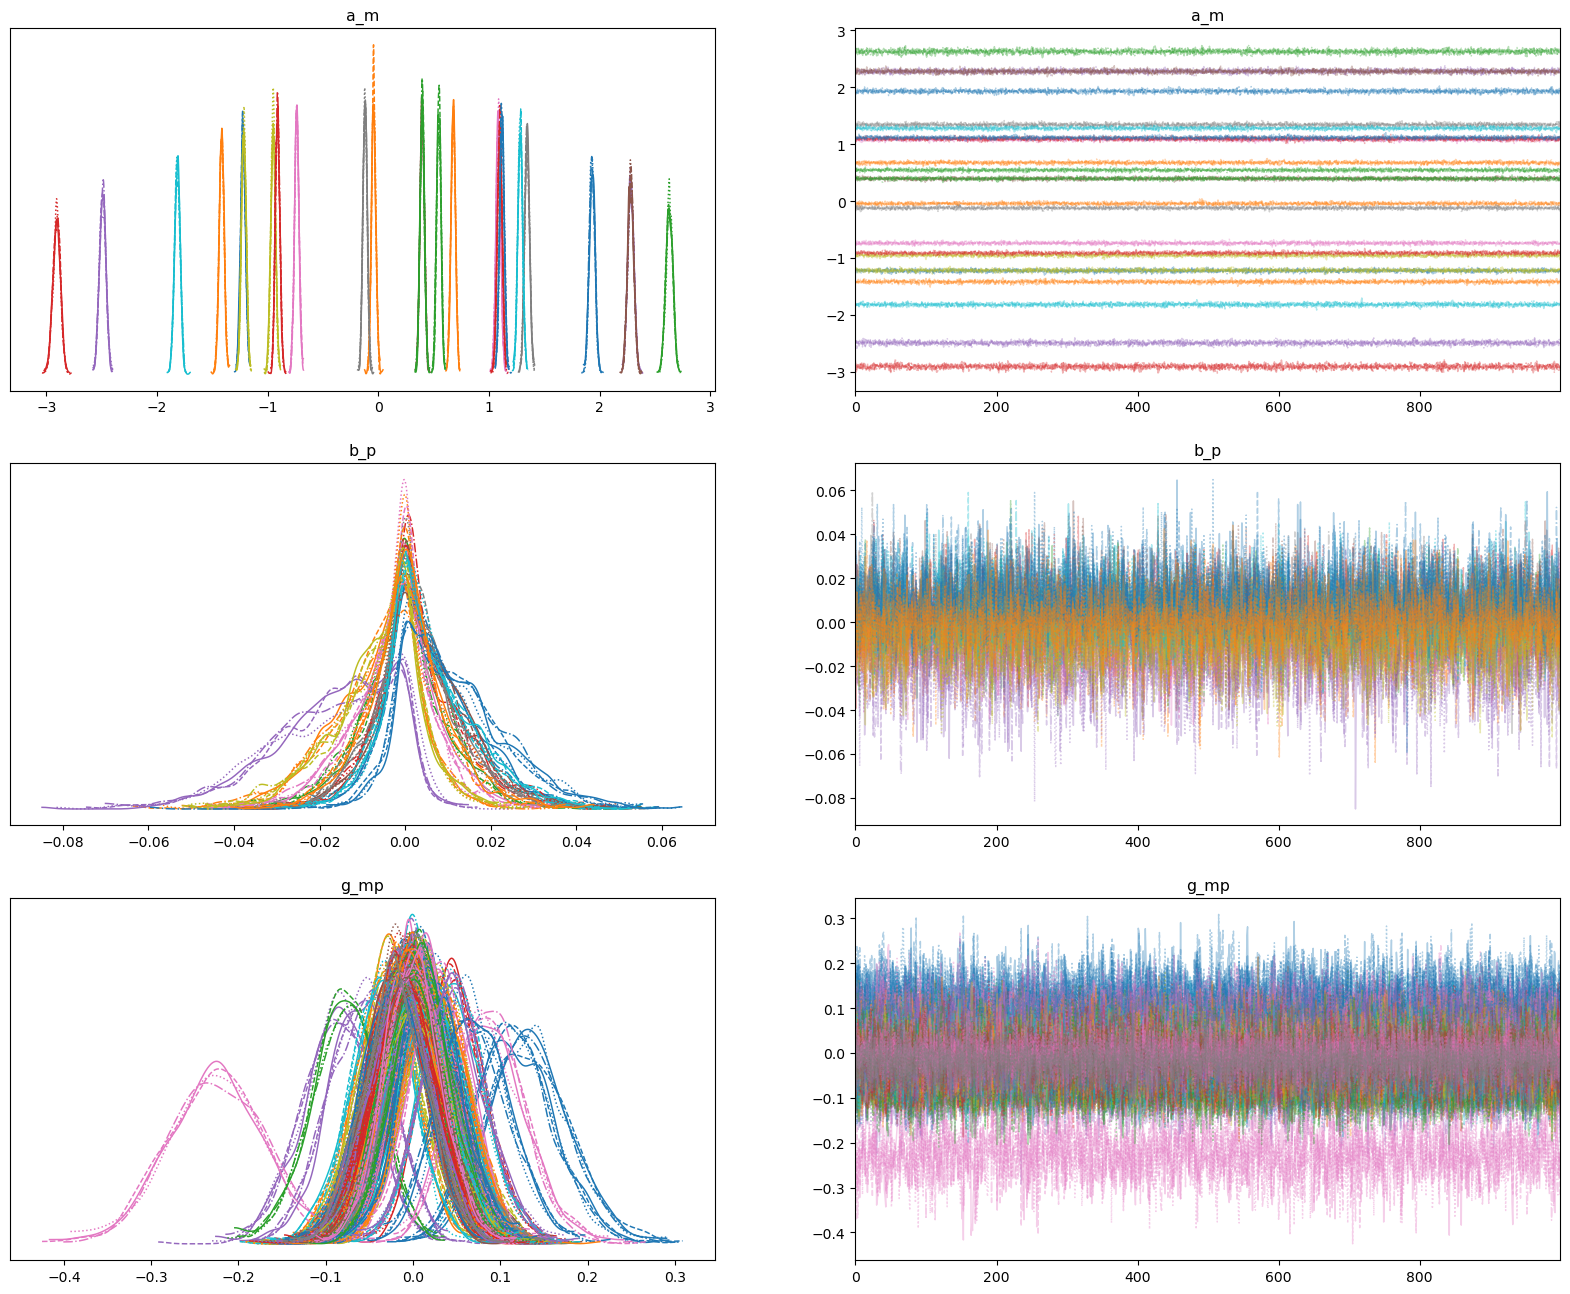

In [10]:
import matplotlib.pyplot as plt

axes = az.plot_trace(idata, var_names=['a_m', 'b_p', 'g_mp'], figsize=(20, 16))
#for ax in axes[:, 1]:  # Assumes trace plots are in the second column
#    ax.set_visible(False)
#plt.show()

### Transformed effects

In [14]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("model_3_trace_1000.nc") # REPLACE
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    'a_m': logit_to_probability,
    'b_p': logit_to_probability,
    'g_mp':logit_to_probability
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata_transformed, variable_list, hdi_prob=0.89)

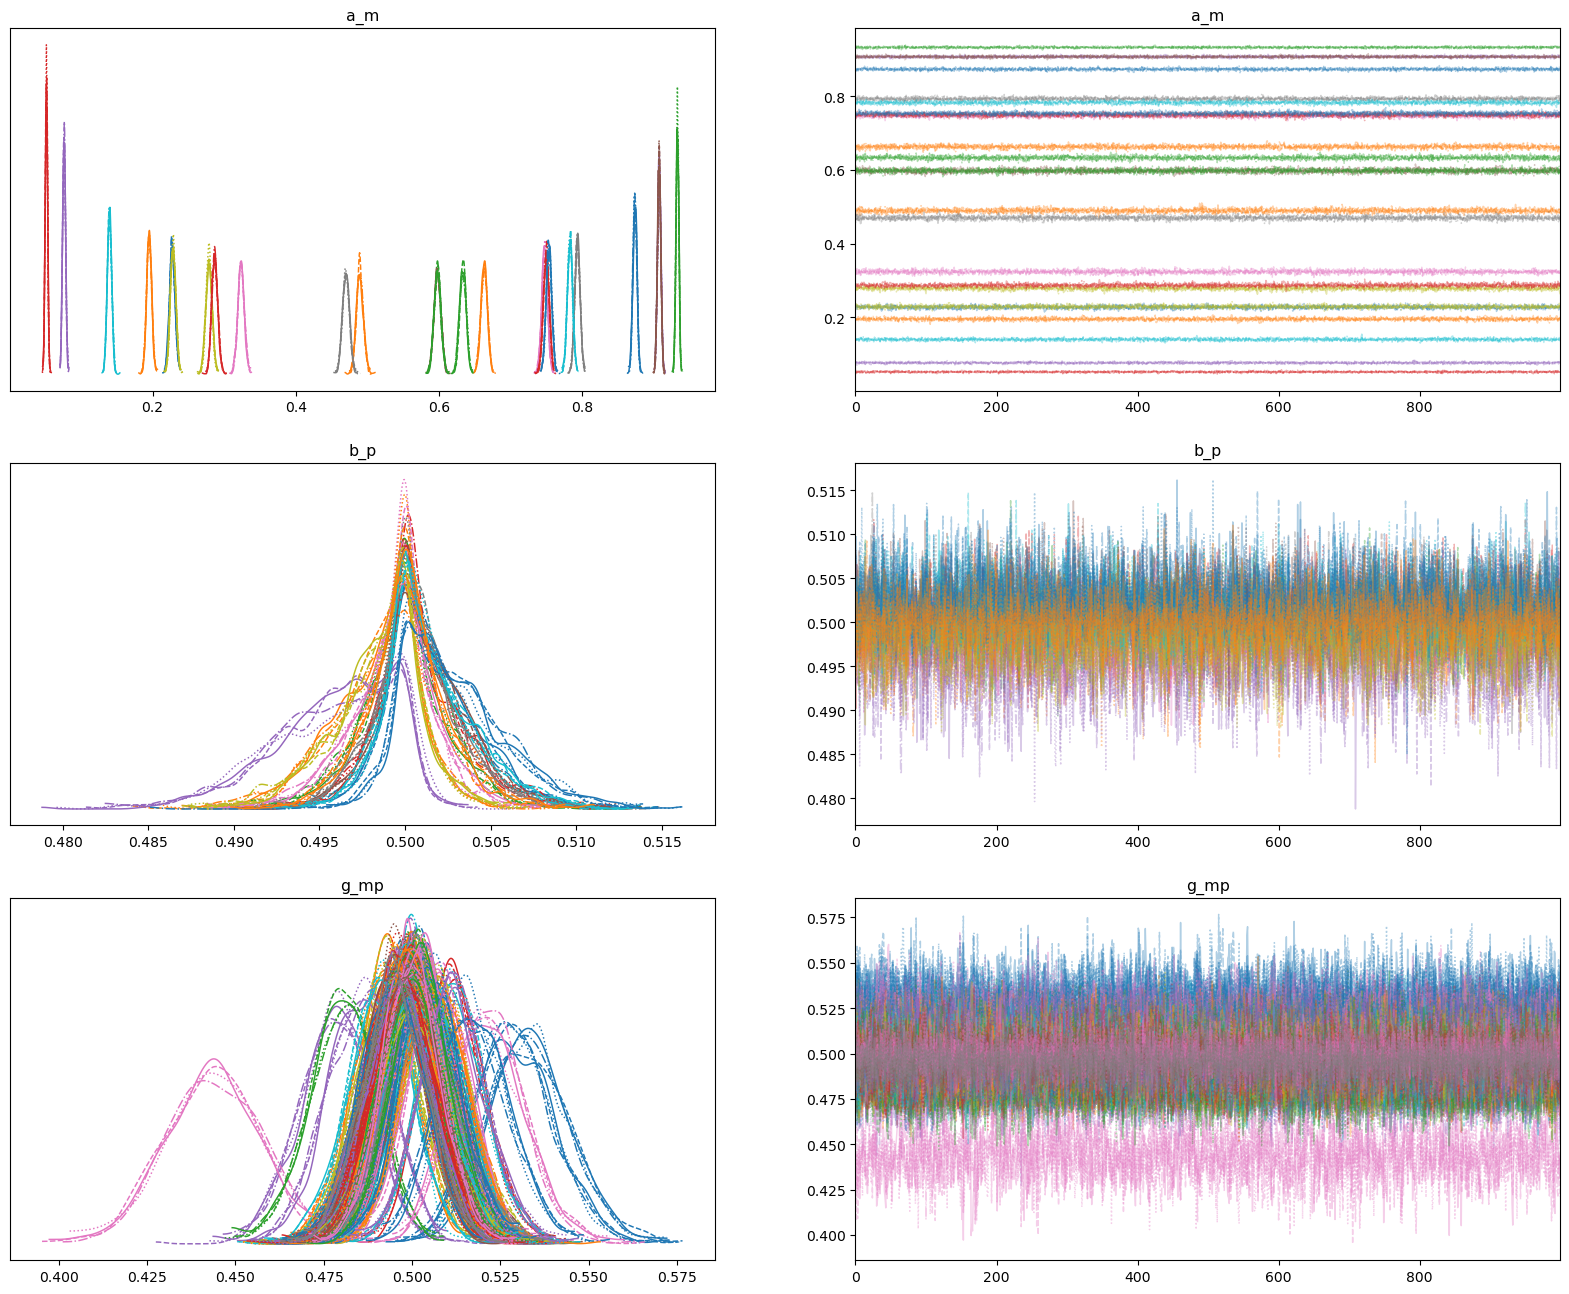

In [15]:
axes = az.plot_trace(idata_transformed, var_names=['a_m', 'b_p', 'g_mp'], figsize=(20, 16))